# Hidden Code for Graphics in the Lab

This code is hidden for one of three reasons:

- It reveals answers to the code for the projects
- It is only for a graphic and nothing more
- Or it is a work-in-progress and should not be revealed to the public until it is refined.



## Project 1, Prelab 1/2 code and graphics

In [ ]:
# Defining a Pert Distribution in Python based on: https://pypi.org/project/pertdist/ project. 
# Modified-PERT has four parameters: minimum (a), most likely (b) maximum (c), and lambda, and when
# lambda equals four, it is the same as the pert distribution. 

from scipy import stats as sps
import numpy as np

class pertm_gen(sps.rv_continuous):
    '''modified beta_PERT distribution'''

    def _shape(self, min, mode, max, lmb):
        s_alpha = 1+ lmb*(mode - min)/(max-min)
        s_beta = 1 + lmb*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        z = (x - min) / (max - min)
        cdf = sps.beta.cdf(z, s_alpha, s_beta)
        return cdf

    def _ppf(self, p, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        ppf = sps.beta.ppf(p, s_alpha, s_beta)
        ppf = ppf * (max - min) + min
        return ppf

    def _mean(self, min, mode, max, lmb):
        mean = (min + lmb * mode + max) / (2 + lmb)
        return mean

    def _var(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = (mean - min) * (max - mean) / (lmb + 3)
        return var

    def _skew(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        skew1 = (min + max - 2*mean) / 4
        skew2 = (mean - min) * (max  - mean)
        skew2 = np.sqrt(7 / skew2)
        skew = skew1 * skew2
        return skew

    def _kurt(self, min, mode, max, lmb):
        a1,a2 = self._shape(min, mode, max, lmb)
        kurt1 = a1 + a2 +1
        kurt2 = 2 * (a1 + a2)**2
        kurt3 = a1 * a2 * (a1 + a2 - 6)
        kurt4 = a1 * a2 * (a1 + a2 + 2) * (a1 + a2 + 3)
        kurt5 = 3 * kurt1 * (kurt2 + kurt3)
        kurt = kurt5 / kurt4 -  3                
        return kurt

    def _stats(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = self._var(min, mode, max, lmb)
        skew = self._skew(min, mode, max, lmb)
        kurt = self._kurt(min, mode, max, lmb)
        return mean, var, skew, kurt

pertm = pertm_gen(name="pertm") # Building a "callable" function for the pert class

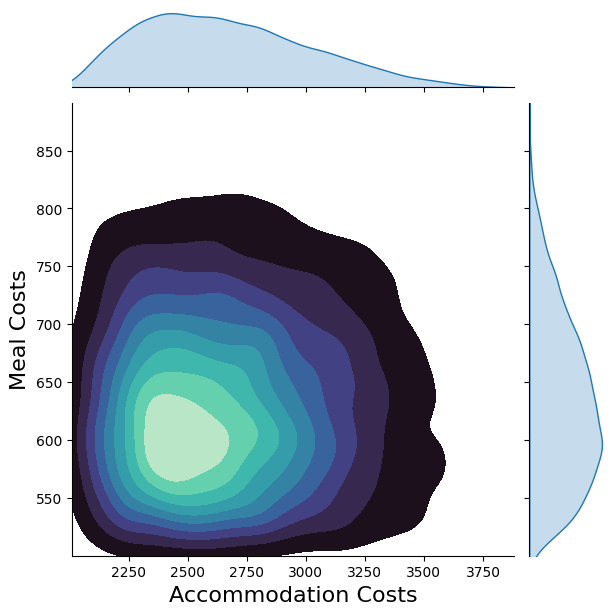

In [ ]:
# Gaussian Copula Construction (Based on https://towardsdatascience.com/python-monte-carlo-simulations-copulas-unchained-ff29d051c0a0/)
# and Project 1, which was a mixture between an example from the literature: https://www.youtube.com/watch?v=0RiEquwDjNg and the authors)

# Parameters
# ---------------------------------------
# Plane Fair: Triangular/PERT (5_000, 7_000, 12_000) X
# Accommodation Costs: Triangular/PERT (2_000, 2_500, 4_000) X
# Meals: Triangular/PERT (500, 600, 900) X
# Shopping Expenses: Deterministic(1_000) X
# Holiday Tours: Uniform (1_500, 4_000) X
# Clothing: Triangular/PERT (300, 400, 500) X
# Foreign Exchange: Triangular/PERT (3.75, 4.00, 4.50) X

# Discrete Events
# ----------------------------------------------
# Medical Emergency with two components: (likelihood: bernoulli[0.1] ), (impact: uniform[1_000, 5_000] )
# Theft of Belongings with two components: (likelihood: bernoulli[0.1] ), (impact: triangular[500, 750, 2_000] )

import scipy as sp
import seaborn as sn
import matplotlib.pyplot as mp

N = 10_000 # generating 10,000 random variates

# Matrix from Project 1: Accommodation, Meals, Holiday Tours
c_target = np.array([[1.0, 0.85, 0.85],
                     [0.85, 1.0, 0.85],
                     [0.85, 0.85, 1.0]])

r0 = [0] * c_target.shape[0]                       # Zero-Vector that is the same size of corr matrix.
mv_norm = sps.multivariate_normal(mean=r0, cov=c_target)    # means =  Zero-vector; cov = targeted corr matrix
rand_norm_var = mv_norm.rvs(N)                               # draw N random variates

rand_U = sps.norm.cdf(rand_norm_var)   # normalize random variates into U[0,1]


# Distribution parameters for non-correlated distribution metrics:
pfmin, pfmode, pfmax, pflmb = 5_000.0, 7_000.0, 12_000.0, 4.0 # Plane Fare, P: Triangular/PERT (5_000, 7_000, 12_000) 
cmin, cmode, cmax, clmb = 300, 400, 500, 4.0                  # Clothing, C: Triangular/PERT (300, 400, 500)
exmin, exmode, exmax, exlmb = 3.75, 4.00, 4.50, 4.0           # Foreign Exchange, FE: Triangular/PERT (3.75, 4.00, 4.50)

# Correlated Distribution Parameters:
acmin, acmode, acmax, aclmb = 2_000.0, 2_500.0, 4_000.0, 4.0  # Accommodation Costs, AC: Triangular/PERT (2_000, 2_500, 4_000)
fmin, fmode, fmax, flmb = 500, 600, 900, 4.0                  # Meals, M: Triangular/PERT (500, 600, 900)
ms, ss = 1_500, 4_000                                         # Holiday Tours HT: uniformly distributed [1_500, 4_000]

# Deterministic Distributions
o = 1_000                                                     # shopping, deterministic (1_000)

# Discrete Events and Distributions
ME_Likelihood = 0.1
Theft_Likelihood = 0.1

MEmin, MEmax = 1_000, 5_000.0
Theftmin, Theftode, Theftmax, Theftlmb = 500.0, 750.0, 2_000.0, 4.0

# instantiate the marginal distributions, one for each of the input variables
d_P = pertm(pfmin, pfmode, pfmax, pflmb)   # PF
d_P_C = pertm(cmin, cmode, cmax, clmb)  # Clothing
d_P_FE = pertm(exmin, exmode, exmax, exlmb)  # FE

# Correlated Marginals
d_P_AC = pertm(acmin, acmode, acmax, aclmb) # AC
d_P_M = pertm(fmin, fmode, fmax, flmb) # M
d_P_HT = sps.uniform(ms, ss) # HT

# Discrete Events (This might not work...)
d_ME_Impact = sps.uniform(MEmin, MEmax)
d_Theft_Impact = pertm(Theftmin, Theftode, Theftmax, Theftlmb)

d_ME_Prob = sps.bernoulli(Theft_Likelihood)
d_Theft_Prob = sps.bernoulli(Theft_Likelihood)

# Random Samples
rand_P_AC = d_P_AC.rvs(N)               # Accommodation
rand_N1 = d_P_M.rvs(N)                  # Meals
rand_N2 = d_P_HT.rvs(N)                  # Holiday Tours

# Correlated Random Samples
rand_PF = d_P.rvs(N)                   # PF
rand_C = d_P_C.rvs(N)                  # Clothing
rand_FE = d_P_FE.rvs(N)                # FE 

# Discrete Event Random Samples

rand_ME_Impact = d_ME_Impact.rvs(N)         
rand_Theft_Impact = d_Theft_Impact.rvs(N)  

rand_ME_Prob = d_ME_Prob.rvs(N)                  
rand_Theft_Prob = d_Theft_Prob.rvs(N)                 


def plotcorr(rand1, rand2, name1, name2):
    min1, max1, min2, max2 = rand1.min(), rand1.max(), rand2.min(), rand2.max()
    # h = sn.jointplot(x=rand1, y=rand2, kind='kde', xlim=(min1, max1), ylim=(min2, max2)) # Without Fill
    h = sn.jointplot(x=rand1, y=rand2, kind='kde', xlim=(min1, max1), ylim=(min2, max2),
    # Additional Fill Options:
    fill=True,
    thresh=0.05,      # Extend shading to lower density areas (had to look this up)
    levels=10,
    cmap="mako",     # Colormap (for example:, "blues" "viridis", "mako", "rocket")
    alpha=1
    )
    h.set_axis_labels(name1, name2, fontsize=16);

s = plotcorr(rand_P_AC, rand_N1, "Accommodation Costs", "Meal Costs")

Graphic 1: Gaussian_Coupla

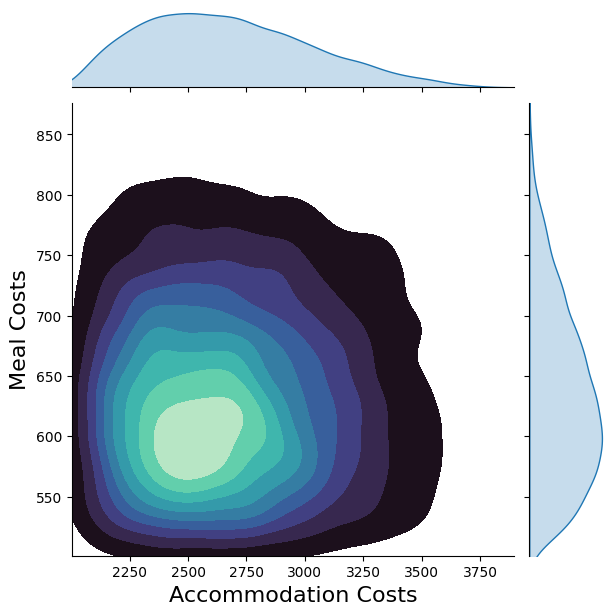

In [ ]:
#| label: copula
s


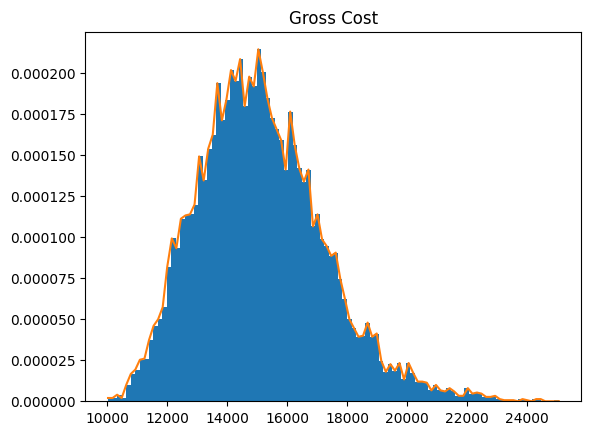

Statistical Information
----------------------
Kurtosis: 0.6046434173394539
Skewness: 0.5982621749140496
Median Cost: 14972.078921828983
Mean Cost: 15143.692829984537


In [35]:
# Project 1 Simulation 

# Random Samples
rand_P_AC = d_P_AC.rvs(N)               # Accommodation
rand_M = d_P_M.rvs(N)                  # Meals
rand_HT = d_P_HT.rvs(N)                  # Holiday Tours

# Correlated Random Samples
rand_PF = d_P.rvs(N)                   # PF
rand_C = d_P_C.rvs(N)                  # Clothing
rand_FE = d_P_FE.rvs(N)                # FE 

# Discrete Event Random Samples
rand_ME_Impact = d_ME_Impact.rvs(N)         
rand_Theft_Impact = d_Theft_Impact.rvs(N)  

rand_ME_Prob = d_ME_Prob.rvs(N)                  
rand_Theft_Prob = d_Theft_Prob.rvs(N) 

# output variables
GP = rand_P_AC + rand_M + rand_HT + rand_PF + rand_C + rand_FE + (rand_ME_Impact * rand_ME_Prob) + (rand_Theft_Impact * rand_Theft_Prob) # simulation output: Total Cost

def plothist(data, name):
    hist = np.histogram(data, bins=100)
    histdist = sps.rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    mp.title(name)
    mp.hist(data, density=True, bins=100)
    mp.plot(X, histdist.pdf(X), label="pdf")
    mp.show()


plothist(GP, "Gross Cost")

mean_value = np.mean(GP)
median_value = np.median(GP)
skewness = sps.skew(GP)
kurtosis = sps.kurtosis(GP)

print("Statistical Information")
print("----------------------")
print(f"Kurtosis: {kurtosis}")
print(f"Skewness: {skewness}")
print(f"Median Cost: {median_value}")
print(f"Mean Cost: {mean_value}")

# Prelab 2 and Lab 2

In [40]:
!pip install monaco numba bokeh!=3.0.*,>=2.4.2

In [41]:
import numpy as np
import pandas as pd
from scipy import stats as stats

def retirement_example_run(yearly_returns, beginning_investments, yearly_spending):
    # yearly_returns: A list of yearly investment returns
    # beginning_investments: The money initially invested
    # yearly_spending: The money withdrawn each year

    nyears = len(yearly_returns)

    starting_balance = np.ones(nyears)*beginning_investments
    ending_balance = np.zeros(nyears)

    for i in range(nyears):
        if i > 0:
            starting_balance[i] = ending_balance[i-1]
        ending_balance[i] = max(starting_balance[i]*(1+yearly_returns[i]) - yearly_spending, 0)

    dates = pd.date_range(start='2020-01-01', periods=nyears, freq='YS')
    df = pd.DataFrame({'Returns'         : yearly_returns,
                       'Spending'        : yearly_spending,
                       'Starting Balance': starting_balance,
                       'Ending Balance'  : ending_balance},
                      index=dates)

    return (df)

def retirement_example_postprocess(case, df):
    # Note that for pandas dataframes, you must explicitly include the index
    case.addOutVal('Date', df.index)
    case.addOutVal('Returns', df['Returns'])
    case.addOutVal('Spending', df['Spending'])
    case.addOutVal('Starting Balance', df['Starting Balance'])
    case.addOutVal('Ending Balance', df['Ending Balance'])

    case.addOutVal('Average Returns', stats.gmean(1 + df['Returns']) - 1)
    case.addOutVal('Final Balance', df['Ending Balance'][-1])
    wentbroke = 'No'
    if df['Ending Balance'][-1] == 0:
        wentbroke = 'Yes'
    case.addOutVal('Broke', wentbroke, valmap={'Yes': 0, 'No': 1})


def retirement_example_preprocess(case):
    nyears = case.constvals['nyears']
    yearly_returns = []
    for i in range(nyears):
        yearly_returns.append(case.invals[f'Year {i} Returns'].val)

    beginning_investments = case.invals['Beginning Balance'].val
    yearly_spending = 50000  # total number of nodes

    return (yearly_returns, beginning_investments, yearly_spending)

/home/glawrence/.conda/envs/spyder-env/lib/python3.13/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35179 instead
  warnings.warn(


Dask cluster initiated with 5 workers, 20 threads, 62.42 GiB memory.
Dask dashboard link: http://127.0.0.1:35179/status
Running 'retirement' Monte Carlo simulation with 101/101 cases...
Drawing random samples for 31 input variables via the 'random' method... Done
Generating cases... Done
Preprocessing, running, and postprocessing 303 cases...


/tmp/ipykernel_7028/1950643737.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_7028/1950643737.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_7028/1950643737.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/tmp/ipykernel_7028/1950643737.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

Simulation complete! Runtime: 0:00:10.732473


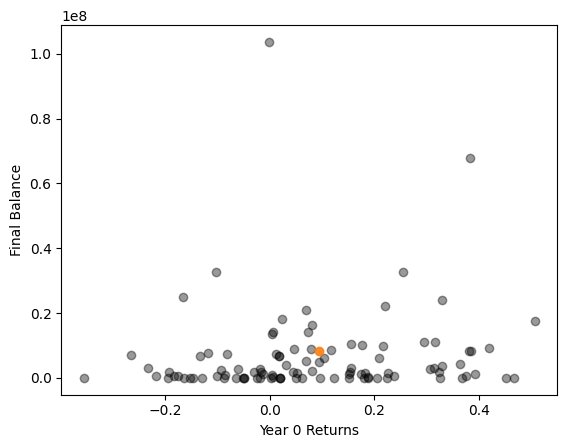

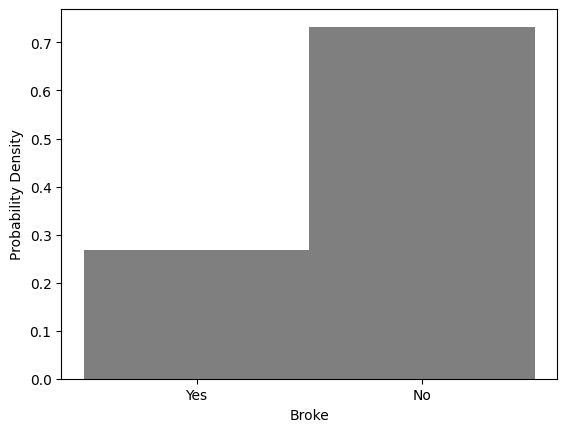

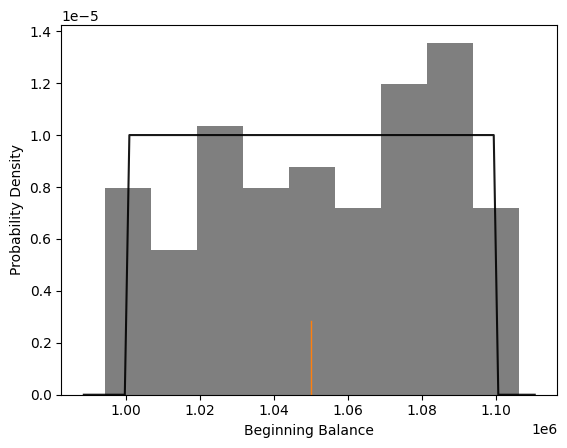

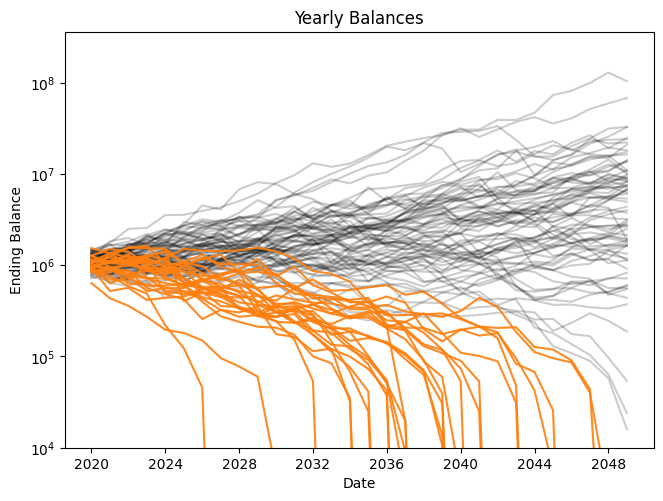

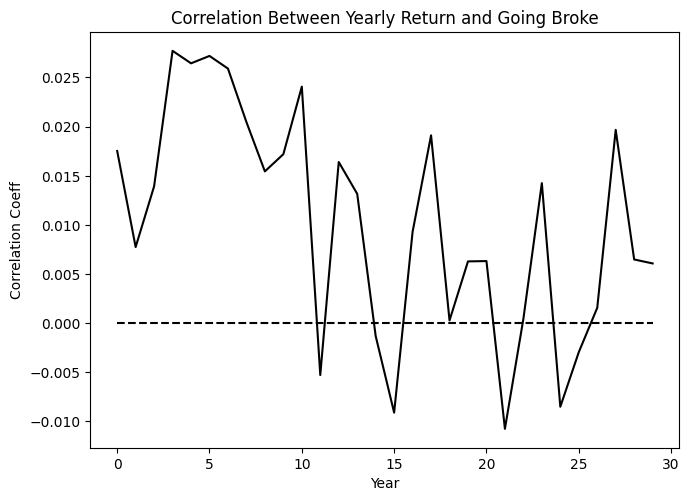

In [ ]:
# This is a modification on the example case from github.com/scottshambaugh/monaco/blob/main/examples/early_retirement_investment_portfolio/retirement_example_run.py
# combined with some random ideas from the author.

# $p_0 = 10000$, $r = 25000$, $t = 40$, and $s = 10,000$

from scipy.stats import norm, uniform
import monaco as mc
import matplotlib.pyplot as plt
import numpy as np

fcns = {'preprocess' : retirement_example_preprocess,
        'run'        : retirement_example_run,
        'postprocess': retirement_example_postprocess}

ndraws = 100
seed = 12362397

def retirement_example_monte_carlo_sim():

    sim = mc.Sim(name='retirement', ndraws=ndraws, fcns=fcns,
                 firstcaseismedian=True, samplemethod='random',
                 seed=seed, singlethreaded=False,
                 savecasedata=False,
                 verbose=True, debug=True)

    sp500_mean = 0.114
    sp500_stdev = 0.197
    inflation = 0.02 # In the model, we assume inflatio would be factored into the return rate. 
    nyears = 40 # t = 40

    for i in range(nyears):
        sim.addInVar(name=f'Year {i} Returns', dist=norm,
                     distkwargs={'loc': (sp500_mean - inflation), 'scale': sp500_stdev})

    sim.addInVar(name='Beginning Balance', dist=uniform,
                 distkwargs={'loc': 1000000, 'scale': 100000})
    sim.addConstVal(name='nyears', val=nyears)

    sim.runSim()

    wentbrokecases = [i for i, e in enumerate(sim.outvars['Broke'].vals) if e == 'Yes']

    mc.plot(sim.invars['Year 0 Returns'], sim.outvars['Final Balance'],
            highlight_cases=0, cov_plot=False)
    mc.plot(sim.outvars['Broke'])
    mc.plot(sim.invars['Beginning Balance'], highlight_cases=0)
    fig, ax = mc.plot(sim.outvars['Date'], sim.outvars['Ending Balance'],
                      highlight_cases=wentbrokecases, title='Yearly Balances')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=1e4)
    fig.set_size_inches(7.6, 5.4)

    sim.genCovarianceMatrix()
    fig = plt.figure()
    yearly_return_broke_corr = []
    for i in range(nyears):
        corr = sim.covs[sim.covvarlist.index('Broke')][sim.covvarlist.index(f'Year {i} Returns')]
        yearly_return_broke_corr.append(corr)
    plt.plot(range(nyears), yearly_return_broke_corr, 'k')
    plt.plot(range(nyears), np.zeros(nyears), 'k--')
    plt.title('Correlation Between Yearly Return and Going Broke')
    plt.ylabel('Correlation Coeff')
    plt.xlabel('Year')
    fig.set_size_inches(7.6, 5.4)
    plt.show()

    return sim


if __name__ == '__main__':
    sim = retirement_example_monte_carlo_sim()

## Project 2, Prelab 3/4 Code and Graphics